# Bank Classification Problem

### This project is for Artificial Intelligence class ministred by Lucas Baggio from FATEC Ribeirão Preto.



***
![alt text](http://www.fatecrp.edu.br/wp-content/themes/fatecrp/dist/img/logo.png)
***



#### The goal of this model is to predict if the client will subscribe (Yes/No) to a term deposit (bank product) based on a marketing campaign. The dataset is available in: https://www.kaggle.com/rouseguy/bankbalanced#bank.csv

# First Step

### Import our classes
### Inicialize Spark object
### Read csv as DataFrame

In [1]:
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
import matplotlib.pyplot as plt
import pandas as pd

import seaborn as sns
import six

sc = SparkSession.builder \
                 .appName('bank-classification') \
                 .getOrCreate()

df = sc.read.csv('dataset/bank.csv', header = True, inferSchema = True)

### Old Schema

In [2]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- contact: string (nullable = true)
 |-- day: integer (nullable = true)
 |-- month: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)



## Understand our variables

### Categorical

* Marital - (Married , Single , Divorced),
* Job - (Management, BlueCollar, Technician, entrepreneur, retired,admin., services, selfemployed, housemaid, student, unemployed, unknown)
* Contact - (Telephone, Cellular, Unknown)
* Education - (Primary, Secondary, Tertiary, Unknown)
* Month - (Jan, Feb, Mar, Apr, May, Jun, Jul, Aug, Sep, Oct, Nov, Dec): last contact month
* Poutcome - (Success, Failure, Other, Unknown): outcome of the previous marketing campaign.
* Housing - (Yes/No): Has housing loan?
* Loan - (Yes/No): Has personal loan?
* Deposit - (Yes/No)
* Default - (Yes/No): has credit in default?


### Numerical

* Age
* Balance
* Day_of_week: last contact day of week
* Duration: last contact duration, in seconds.
* Campaign: number of contacts performed during this campaign.
* Pdays: number of days that passed by after client was last contacted from a previous campaign.
* Previous: number of contacts performed before this campaign.



# Data Exploration

#### Next, we check if the dataset has any null value

In [3]:
df_null = df.toPandas()
df_null[df_null.isnull().any(axis=1)].count()

age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
deposit      0
dtype: int64

### Some statistics about our dataset

In [4]:
features_int = [t[0] for t in df.dtypes if t[1] == 'int']
df.select(features_int).describe().toPandas().transpose()

,0,1,2,3,4
summary,count,mean,stddev,min,max
age,11162,41.231947679627304,11.913369192215518,18,95
balance,11162,1528.5385235620856,3225.413325946149,-6847,81204
day,11162,15.658036194230425,8.420739541006462,1,31
duration,11162,371.99381831213043,347.12838571630687,2,3881
campaign,11162,2.508421429851281,2.7220771816614824,1,63
pdays,11162,51.33040673714388,108.75828197197717,-1,854
previous,11162,0.8325568894463358,2.292007218670508,0,58


#### Distribution of Age

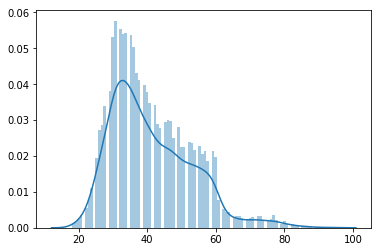

In [5]:
age = df.select('age').toPandas()
sns.distplot(age, bins=100)

#### Distribution of duration

#### People who made a deposit Vs Job category

In [6]:
jobs = df.select('job').distinct()
# df.select('job').distinct().show()

jobs = ['management', 'retired', 'unknown', 'self-employed', 'student', 'blue-collar', 
        'entrepreneur', 'admin.', 'technician', 'services', 'housemaid', 'unemployed']

for j in jobs:
    print("{:15} : {:5}". format(j, len(df[(df.deposit == "yes") & (df.job ==j)].toPandas())))

management      :  1301
retired         :   516
unknown         :    34
self-employed   :   187
student         :   269
blue-collar     :   708
entrepreneur    :   123
admin.          :   631
technician      :   840
services        :   369
housemaid       :   109
unemployed      :   202


#### Scatterplot between age and balance

##### Across all ages, majority of people have savings of less than 20000.

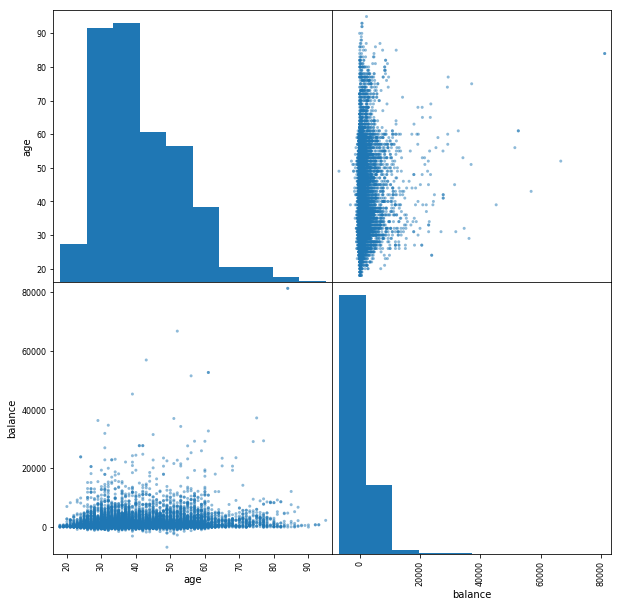

In [7]:
data = df.select('age', 'balance').toPandas()
pd.plotting.scatter_matrix(data, figsize=(10, 10));

### We can see student, retired and unemployed are more likely to deposit.

In [8]:
depositmapping={'yes':1,'no': 0}
data_plot = df['job', 'deposit'].toPandas()

data_plot['deposit'] = data_plot['deposit'].map(depositmapping)

data_plot.groupby('job',as_index=False).mean().sort_values('deposit',ascending=False)

,job,deposit
8,student,0.747222
5,retired,0.663239
10,unemployed,0.565826
4,management,0.507015
11,unknown,0.485714
0,admin.,0.473013
6,self-employed,0.461728
9,technician,0.460779
7,services,0.399783
3,housemaid,0.397810


### Marital status is of not much significance when deciding whether the person will deposit or not. Therefore we eliminate this parameter.

In [9]:
data_plot = df['marital', 'deposit'].toPandas()
data_plot['deposit'] = data_plot['deposit'].map(depositmapping)

data_plot.groupby('marital',as_index=False).mean().sort_values('deposit',ascending=False)

,marital,deposit
2,single,0.543491
0,divorced,0.481052
1,married,0.433790


### From the following data we can say that the more educated the person is the more likely he is to deposit.

In [10]:
data_plot = df['education', 'deposit'].toPandas()
data_plot['deposit'] = data_plot['deposit'].map(depositmapping)

data_plot.groupby('education',as_index=False).mean().sort_values('deposit',ascending=False)

,education,deposit
2,tertiary,0.541068
3,unknown,0.507042
1,secondary,0.447407
0,primary,0.394000


### Who did not have credit in default, deposited more.

In [11]:
data_plot = df['default', 'deposit'].toPandas()
data_plot['deposit'] = data_plot['deposit'].map(depositmapping)

data_plot.groupby('default',as_index=False).mean().sort_values('deposit',ascending=False)

,default,deposit
0,no,0.476351
1,yes,0.309524


### People who did not have personal loan, deposited more.

In [12]:
data_plot = df['loan', 'deposit'].toPandas()
data_plot['deposit'] = data_plot['deposit'].map(depositmapping)

data_plot.groupby('loan',as_index=False).mean().sort_values('deposit',ascending=False)

,loan,deposit
0,no,0.495259
1,yes,0.331507


### The way the customer was contacted has little to do with whether the person has deposited, so we drop this variable.

In [13]:
data_plot = df['contact', 'deposit'].toPandas()
data_plot['deposit'] = data_plot['deposit'].map(depositmapping)

data_plot.groupby('contact',as_index=False).mean().sort_values('deposit',ascending=False)

,contact,deposit
0,cellular,0.543273
1,telephone,0.503876
2,unknown,0.225916


### Generally, people do deposit in end of year.

In [14]:
data_plot = df['month', 'deposit'].toPandas()
data_plot['deposit'] = data_plot['deposit'].map(depositmapping)

data_plot.groupby('month',as_index=False).mean().sort_values('deposit',ascending=False)

,month,deposit
2,dec,0.909091
7,mar,0.898551
11,sep,0.843260
10,oct,0.823980
0,apr,0.625135
3,feb,0.568299
1,aug,0.452930
6,jun,0.446809
9,nov,0.427359
5,jul,0.414135


### People who have deposited previously, deposited again.

In [15]:
data_plot = df['poutcome', 'deposit'].toPandas()
data_plot['deposit'] = data_plot['deposit'].map(depositmapping)

data_plot.groupby('poutcome',as_index=False).mean().sort_values('deposit',ascending=False)

,poutcome,deposit
2,success,0.913165
1,other,0.571695
0,failure,0.503257
3,unknown,0.406678


## Correlation Matrix

### The correlation matrix shows what are feature's behaviors according by other.

#### At heatmap, we can see the feature pdays has a strong relation with previous. It means that dataset has data repetead, but both features has sense of being dependent, cuz how many days passed after client was last contacted from a previous campaign, less will be number of contacts performed before this campaign.

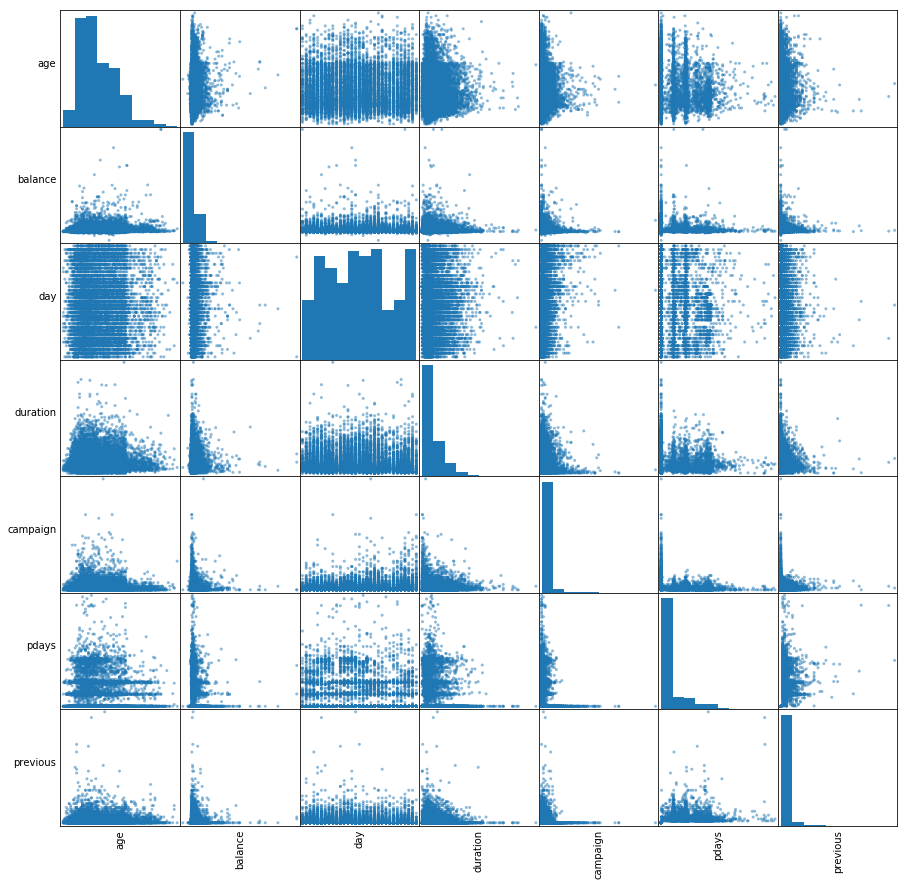

In [16]:
# Use only 1 Core to proccess

data = df.select(features_int).toPandas()
axs = pd.plotting.scatter_matrix(data, figsize=(15, 15));
n = len(data.columns)

for i in range(n):
    v = axs[i, 0]
    v.yaxis.label.set_rotation(0)
    v.yaxis.label.set_ha('right')
    v.set_yticks(())
    h = axs[n-1, i]
    h.xaxis.label.set_rotation(90)
    h.set_xticks(())

## HeatMap about our features

[Text(0.5, 0, 'age'),
 Text(1.5, 0, 'balance'),
 Text(2.5, 0, 'day'),
 Text(3.5, 0, 'duration'),
 Text(4.5, 0, 'campaign'),
 Text(5.5, 0, 'pdays'),
 Text(6.5, 0, 'previous')]

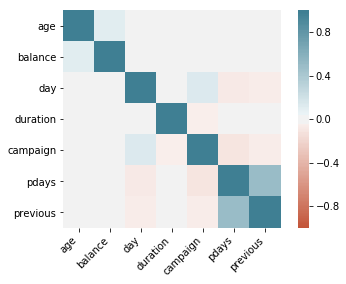

In [17]:
corr = data.corr()

ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
)

### Correlation value between features

In [18]:
for i in df.columns:
    if not(isinstance(df.select(i).take(1)[0][0], six.string_types)):
        print('Correlation to Pdays for ', i, df.stat.corr('pdays',i))

Correlation to Pdays for  age 0.002773834311769581
Correlation to Pdays for  balance 0.017411148632674168
Correlation to Pdays for  day -0.07723161298140313
Correlation to Pdays for  duration -0.027391553245039814
Correlation to Pdays for  campaign -0.10272604750934175
Correlation to Pdays for  pdays 1.0
Correlation to Pdays for  previous 0.5072715883726697


# Data Preparation

In [19]:
df = df.select('age', 'job', 'education', 'default', 'balance', 'housing', 
               'loan', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 
               'deposit', 'month')

cols = df.columns
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)
 |-- month: string (nullable = true)



## StringIndexer

#### Encodes a string column of labels to a column of label indices, the indices are in [0, numLabels], ordered by label frequencies, that's whythe most frequent label gets index 0.

## OneHotEncoderEstimator

#### One hot encoding maps a categorical feature, represented as a label index, to a binary vector with at most a single one-value indicating the presence of a specific feature value from among the set of all feature values. 
#### OneHotEncoderEstimator can transform multiple columns, returning an one-hot-encoded output vector column for each input column.

## VectorAssembler

#### Merge those one-hot-encoded vector into a single feature vector.

In [20]:
numerical_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous']
categorical_features = ['job', 'education', 'default', 'housing', 'loan', 'poutcome', 'month']

all_features = ['age', 'balance', 'duration', 'campaign', 'pdays', 'previous', 'job', 
                'education', 'default', 'housing', 'loan', 'poutcome', 'month']

stages = []

for feature in all_features:
    stringIndexer = StringIndexer(inputCol=feature, outputCol=feature+'Index')
    encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[feature+'classVec'])
    stages+=[stringIndexer, encoder]

label = StringIndexer(inputCol='deposit', outputCol='label')
stages += [label]

assemblerInputs = [c + 'classVec' for c in categorical_features] + numerical_features
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol='features')
stages += [assembler]

## Pipeline

#### A pipeline chains multiple Transformer and Estimator together to specify an ML workflow. 

### Transformers (transform())

#### Is an abstraction that converts one DataFrame into another, by appending one or more columns.

### Estimators (fit())

#### Abstract the concept of a learning algorithm that fits or trains on data. Implements a method fit() that accepts a DataFrame and produces a Model, which is a Transformer.

In [21]:
pipe = Pipeline(stages = stages)
pipe_model = pipe.fit(df)

df = pipe_model.transform(df)
select = ['label', 'features'] + cols

df = df.select(select)
df.printSchema()

root
 |-- label: double (nullable = false)
 |-- features: vector (nullable = true)
 |-- age: integer (nullable = true)
 |-- job: string (nullable = true)
 |-- education: string (nullable = true)
 |-- default: string (nullable = true)
 |-- balance: integer (nullable = true)
 |-- housing: string (nullable = true)
 |-- loan: string (nullable = true)
 |-- duration: integer (nullable = true)
 |-- campaign: integer (nullable = true)
 |-- pdays: integer (nullable = true)
 |-- previous: integer (nullable = true)
 |-- poutcome: string (nullable = true)
 |-- deposit: string (nullable = true)
 |-- month: string (nullable = true)



#### Distribution of data after one-hot-encoding

In [30]:
pd.DataFrame(df.filter('label == 1').take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,1,1,1,1,1
features,"(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,59,56,41,55,54
job,admin.,admin.,technician,services,admin.
education,secondary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,2343,45,1270,2476,184
housing,yes,no,yes,yes,no
loan,no,no,no,no,no
duration,1042,1467,1389,579,673


In [31]:
pd.DataFrame(df.filter('label == 0').take(5), columns=df.columns).transpose()

,0,1,2,3,4
label,0,0,0,0,0
features,"(0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","(0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
age,57,45,48,34,37
job,retired,admin.,blue-collar,admin.,entrepreneur
education,primary,secondary,secondary,secondary,tertiary
default,no,no,no,no,no
balance,604,0,238,673,7944
housing,no,yes,yes,yes,no
loan,no,no,yes,no,no
duration,187,102,118,89,102


### Separated the dataset to train and to test

In [24]:
train, test = df.randomSplit([0.7, 0.3], seed = 2018)
print("Training Dataset Count: " + str(train.count()))
print("Test Dataset Count: " + str(test.count()))

Training Dataset Count: 7764
Test Dataset Count: 3398


## Execute the Random Forrest Model provide by Spark
##### Reference: https://spark.apache.org/docs/2.2.0/mllib-decision-tree.html

### Setting HyperParameter for the model

##### maxDepth = max number of levels in each decision tree.
    . Increasing the depth makes the model more expressive and powerful. However, deep trees take longer to train and are also more prone to overfitting.
    
##### numTrees = number of trees in the foreset.
    . Increasing the number of trees will decrease the variance in predictions, improving the model’s  test-time accuracy.

##### featureSubsetStrategy = number of features to use as candidates for splitting at each tree node.
    . The number is specified as a fraction or function of the total number of features. Decreasing this number  will speed up training, but can sometimes impact performance if too low.
    
##### maxBins = Number of bins used when discretizing continuous features.
    . Increasing maxBins allows the algorithm to consider more split candidates and make fine-grained split decisions.

##### impurity = is a measure of the homogeneity of the labels at the node.
    . The current implementation provides two  impurity measures for classification (Gini impurity and entropy)  and one impurity measure for regression (variance).
    
    . Gini measurement is the probability  of a random sample being classified incorrectly if we randomly pick a label according to the distribution in a branch.
    
    . Entropy is a measurement of information  (or rather lack thereof). You calculate the information gain by making a split. Which is the difference in entripies. This measures how you reduce the uncertainty about the label.



In [29]:
random_forest = RandomForestClassifier(featuresCol = 'features', labelCol = 'label', 
                                       numTrees=150, featureSubsetStrategy="auto",
                                       impurity='gini', maxDepth=15, maxBins=32)
rfModel = random_forest.fit(train)
predictions = rfModel.transform(test)

![DeepinScreenshot_select-area_20190610192757.png](attachment:DeepinScreenshot_select-area_20190610192757.png)

## Result

#### prediction column = Predicted label

#### rawPrediction = Vector of length # classes, with the counts of training instance labels at the tree node which makes the prediction

#### probability = 	Vector of length # classes equal to rawPrediction normalized to a multinomial distribution

In [26]:
predictions.select('age', 'job', 'label', 'rawPrediction', 'prediction', 'probability') \
           .filter('label == 1').show(10)

+---+----------+-----+--------------------+----------+--------------------+
|age|       job|label|       rawPrediction|prediction|         probability|
+---+----------+-----+--------------------+----------+--------------------+
| 39|management|  1.0|[40.1602790035183...|       1.0|[0.20080139501759...|
| 39|management|  1.0|[35.5648897203697...|       1.0|[0.17782444860184...|
| 40|management|  1.0|[79.1139324181918...|       1.0|[0.39556966209095...|
| 45|management|  1.0|[161.256796754847...|       0.0|[0.80628398377423...|
| 31|management|  1.0|[39.7051844549313...|       1.0|[0.19852592227465...|
| 60|management|  1.0|[54.4273918006330...|       1.0|[0.27213695900316...|
| 28|management|  1.0|[60.7803107048616...|       1.0|[0.30390155352430...|
| 40|management|  1.0|[52.4770160205498...|       1.0|[0.26238508010274...|
| 47|management|  1.0|[56.4940014842817...|       1.0|[0.28247000742140...|
| 59|management|  1.0|[146.184660942522...|       0.0|[0.73092330471261...|
+---+-------

## Evaluation Model

### ROC Curve = Receiver Operating Characteristic
    . Shows how well the created model can distinguish between two things (since it is used for classification). These two things can be 0 or 1, or positive and negative.
    . The ROC has two parameters:
        . True Positive Rate, which is given by true positives / (true positives + false negatives)
        . False Positive Rate, which is given by false positives / (false positives + true negatives)

In [27]:
evaluator = BinaryClassificationEvaluator()

print("Test Area Under ROC: " + str(evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})))

Test Area Under ROC: 0.9094206267050342


### F1 = F-score or F-measure
    . Weighted average of the precision and recall, where an F1 score reaches its best value at 1 and worst score at 0.
    
### Precision
    . The precision is the ratio tp / (tp + fp) where tp is the number of true positives and fp the number of  false positives. The precision is intuitively the ability of the classifier not to label as positive a sample that is negative.

### Recall
    . The recall is the ratio tp / (tp + fn) where tp is the number of true positives and fn the number of false negatives. The recall is intuitively the ability of the classifier to find all the positive samples.

### Weighted Precision
    . Takes the frequency of individual classes into account.

### Weighted Recall
    . Takes the frequency of individual classes into account.

### Accuracy
    . This function computes subset accuracy: the set of labels predicted for a sample must exactly match the corresponding set of labels in y_true.


In [32]:
second_evaluator = MulticlassClassificationEvaluator(predictionCol="prediction")
second_evaluator.evaluate(predictions)

print('F1: {}'.format(evaluator.evaluate(predictions, {second_evaluator.metricName: "f1"})))
print('Precision: {}'.format(evaluator.evaluate(predictions, {second_evaluator.metricName: "precision"})))
print('Recall: {}'.format(evaluator.evaluate(predictions, {second_evaluator.metricName: "recall"})))
print('Weighted Precision: {}'.format(evaluator.evaluate(predictions, 
                                                         {second_evaluator.metricName: "weightedPrecision"})))
print('Weighted Recall: {}'.format(evaluator.evaluate(predictions, 
                                                      {second_evaluator.metricName: "weightedRecall"})))
print('Accuracy: {}'.format(evaluator.evaluate(predictions, {second_evaluator.metricName: "accuracy"})))

F1: 0.9094712748626838
Precision: 0.9094712748626838
Recall: 0.9094712748626838
Weighted Precision: 0.9094712748626838
Weighted Recall: 0.9094712748626838
Accuracy: 0.9094712748626838
